In [1]:
# python -m pip install prophet
# here i will try prophet on the loged data so log(x)

In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date
from datetime import timedelta

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

# facebook prophet requires the data to be in 2 colums named ds and y
# ds will be a datetime column with no timezone data and y the label we are forecasting
# ds must NOT be an index like other machine learning algorithms
df = pd.read_csv('./data/btc-usd-max latest.csv', index_col=0, parse_dates=True )
df = df.resample('D').first()
df.drop(['market_cap', 'total_volume'], axis=1, inplace=True)
df['price'].fillna(method='ffill', inplace=True)

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


dynamic_days = 1550

C:\Users\sagap\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)



C:\Users\sagap\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [2]:
data = df['price'].values
print('Shape of data: ', data.shape)

Shape of data:  (3462,)


In [4]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Train length:  2769
Shape of Train and Test data:  (2769,) (693,)


In [5]:
# Change Shape to 2D data
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Shape of Train and Test data:  (2769, 1) (693, 1)


In [9]:
# split a univariate sequence into supervised learning [Input and Output]
def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback -1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        b = dataset[i+lookback, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [10]:
# Taking Auto-correlation Lag value Greater than 10%
from statsmodels.tsa.stattools import pacf
pacf_value = pacf(data, nlags=20)
lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)

Selected look_back (or lag = ):  2


In [11]:
# Separate Input and Output
train_X, train_y = create_dataset(train_data, lag)
test_X, test_y = create_dataset(test_data, lag)

In [13]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (2766, 2) (2766,)
Shape of test_X and test_y:  (690, 2) (690,)


In [14]:
# how the data looks like
print(train_data[:20])            # original data
for x in range(len(train_X[:20])):
    print(test_X[x], test_y[x], )            # trainX and trainY after lookback

[[135.3  ]
 [141.96 ]
 [135.3  ]
 [117.   ]
 [103.43 ]
 [ 91.01 ]
 [111.25 ]
 [116.79 ]
 [118.33 ]
 [106.4  ]
 [112.64 ]
 [113.   ]
 [118.78 ]
 [113.01 ]
 [114.713]
 [117.18 ]
 [114.5  ]
 [114.156]
 [115.5  ]
 [123.1  ]]
[18753.28892168 17138.0295124 ] 17140.27555252362
[17138.0295124  17140.27555252] 17718.972832629497
[17140.27555252 17718.97283263] 18169.95420978285
[17718.97283263 18169.95420978] 19609.52143957559
[18169.95420978 19609.52143958] 18857.417371118165
[19609.52143958 18857.41737112] 19208.398191994624
[18857.41737112 19208.39819199] 19435.20484740911
[19208.39819199 19435.20484741] 18711.226549886927
[19435.20484741 18711.22654989] 19139.111575237486
[18711.22654989 19139.11157524] 19325.55411859109
[19139.11157524 19325.55411859] 19198.806493935343
[19325.55411859 19198.80649394] 18336.514581297808
[19198.80649394 18336.5145813 ] 18564.986455688137
[18336.5145813  18564.98645569] 18262.058384653155
[18564.98645569 18262.05838465] 18058.027339569555
[18262.05838465 180

In [16]:
# Fix random seed for reproducibility
# Thes seed value helps in initilizing random weights and biases to the neural network.  
np.random.seed(7)

In [17]:
# ML libraries
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import keras

In [18]:
# build the model
model = Sequential()
model.add(Dense(64, input_dim = lag, activation='relu', name= "1st_hidden"))
# model.add(Dense(64, activation='relu', name = '2nd_hidden'))
model.add(Dense(1, name = 'Output_layer', activation='linear'))
# model.add(Activation("linear", name = 'Linear_activation'))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_hidden (Dense)          (None, 64)                192       
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


In [19]:
# fit the data to the model
epoch_number = 100
batches = 64

history = model.fit(train_X, train_y, epochs = epoch_number,
                    batch_size = batches, verbose = 1, shuffle=False, 
                    validation_split=0.1)

Epoch 1/100
39/39 [==============================] - 0s 4ms/step - loss: 9101185.0000 - val_loss: 25832022.0000
Epoch 2/100
39/39 [==============================] - 0s 1ms/step - loss: 2218413.0000 - val_loss: 5114825.0000
Epoch 3/100
39/39 [==============================] - 0s 1ms/step - loss: 263451.1875 - val_loss: 450768.3125
Epoch 4/100
39/39 [==============================] - 0s 1ms/step - loss: 76407.0000 - val_loss: 133339.0156
Epoch 5/100
39/39 [==============================] - 0s 1ms/step - loss: 75298.5078 - val_loss: 129715.9688
Epoch 6/100
39/39 [==============================] - 0s 1ms/step - loss: 75182.8125 - val_loss: 130638.5000
Epoch 7/100
39/39 [==============================] - 0s 1ms/step - loss: 75140.5625 - val_loss: 130564.5938
Epoch 8/100
39/39 [==============================] - 0s 1ms/step - loss: 75095.0234 - val_loss: 130524.7656
Epoch 9/100
39/39 [==============================] - 0s 1ms/step - loss: 75045.4297 - val_loss: 130491.5391
Epoch 10/100
39/39 [

39/39 [==============================] - 0s 1ms/step - loss: 94191.5547 - val_loss: 183697.5469
Epoch 77/100
39/39 [==============================] - 0s 1ms/step - loss: 93945.0547 - val_loss: 183188.0156
Epoch 78/100
39/39 [==============================] - 0s 1ms/step - loss: 93704.2500 - val_loss: 182679.4219
Epoch 79/100
39/39 [==============================] - 0s 1ms/step - loss: 93495.1953 - val_loss: 182185.4375
Epoch 80/100
39/39 [==============================] - 0s 1ms/step - loss: 93372.0078 - val_loss: 181883.3594
Epoch 81/100
39/39 [==============================] - 0s 1ms/step - loss: 93319.6641 - val_loss: 181726.9844
Epoch 82/100
39/39 [==============================] - 0s 1ms/step - loss: 93377.6094 - val_loss: 181764.8750
Epoch 83/100
39/39 [==============================] - 0s 1ms/step - loss: 93489.1875 - val_loss: 181982.4375
Epoch 84/100
39/39 [==============================] - 0s 1ms/step - loss: 93599.6328 - val_loss: 182208.2188
Epoch 85/100
39/39 [============

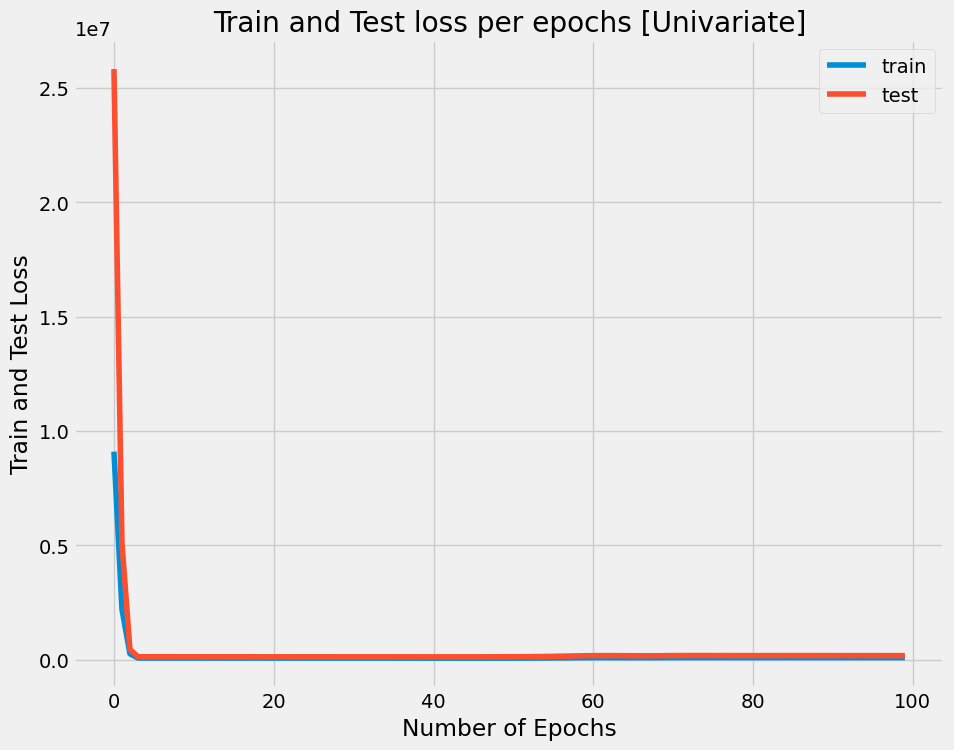

In [20]:
# plot history
plt.clf
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Number of Epochs')
plt.ylabel('Train and Test Loss')
plt.title('Train and Test loss per epochs [Univariate]')
plt.legend()
plt.show()

In [21]:
# Make prediction on the test set
testPredict = model.predict(test_X)
predicted_value = testPredict[:, 0]

22/22 [==============================] - 0s 799us/step


In [24]:
# evaluate the results
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

def evaluate_forecast_results(actual, predicted):
    print('R2 Score: ', round(r2_score(actual, predicted), 2))
    print('MAE : ', round(mae(actual, predicted), 2))
    print('MSE: ', round(mean_squared_error(actual,predicted), 2))
    print('RMSE: ', round(math.sqrt(mean_squared_error(actual,predicted)), 2))
    print('NRMSE: ', NRMSE(actual, predicted))
    print('WMAPE: ', WMAPE(actual, predicted))
    
def NRMSE(actual, predicted):
    rmse = math.sqrt(mean_squared_error(actual,predicted))
    nrmse = rmse / np.mean(actual)
    return round(nrmse, 4)

def WMAPE(actual, predicted):
    abs_error = np.sum(actual - predicted)
    wmape = abs_error / np.sum(actual)
    return round(wmape, 4)

In [25]:
evaluate_forecast_results(test_y, predicted_value)

R2 Score:  0.98
MAE :  1320.97
MSE:  3135045.93
RMSE:  1770.61
NRMSE:  0.0452
WMAPE:  0.0196


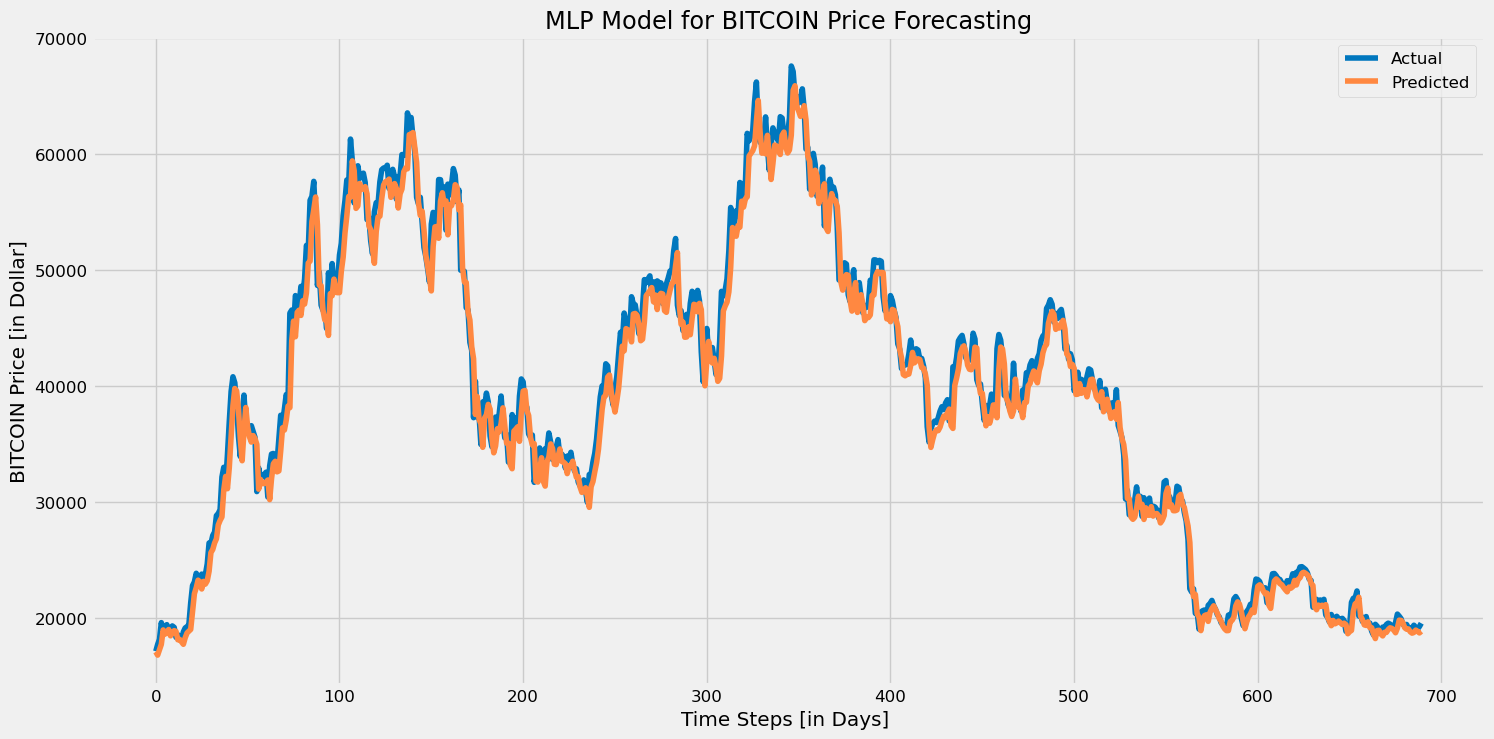

In [26]:
# Here we're plotting Test and Predicted data
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 12})
plt.plot(test_y[:], '#0077be',label = 'Actual')
plt.plot(predicted_value, '#ff8841',label = 'Predicted')
plt.title('MLP Model for BITCOIN Price Forecasting')
plt.ylabel('BITCOIN Price [in Dollar]')
plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.show()

In [27]:
test_X

array([[18753.28892168, 17138.0295124 ],
       [17138.0295124 , 17140.27555252],
       [17140.27555252, 17718.97283263],
       ...,
       [19383.94322009, 19198.10714495],
       [19198.10714495, 19072.78051336],
       [19072.78051336, 19272.92184777]])